## Imports, functions, and classes

In [5]:
import numpy as np
from itertools import combinations_with_replacement
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import scipy.io
import numpy as np

# --- Function: regMatARX ---
def regMatARX(y_signal_in,
              u_signal_in,
              ny: int,
              nu: int):
    """
    Creates the initial ARX regression matrix and the target vector y(k).
    AR (y-lag) terms are NOT negated.

    Args:
        y_signal_in (array-like): Output data vector.
        u_signal_in (array-like): Input data vector.
        ny (int): Number of past y lags (autoregressive order).
        nu (int): Number of past u lags (exogenous input order).

    Returns:
        P0_data (np.ndarray): The ARX regressor matrix. Shape (NP, ny + nu).
        P0_colnames (list): Column names for P0_data.
        y_target (np.ndarray): The target vector y(k). Shape (NP,).
    """
    if not isinstance(y_signal_in, np.ndarray):
        y_signal = np.array(y_signal_in, dtype=float)
    else:
        y_signal = y_signal_in.astype(float)

    if not isinstance(u_signal_in, np.ndarray):
        u_signal = np.array(u_signal_in, dtype=float)
    else:
        u_signal = u_signal_in.astype(float)

    if len(y_signal) != len(u_signal):
        raise ValueError("Input signals y_signal and u_signal must have the same length.")
    if ny < 0 or nu < 0:
        raise ValueError("Lags ny and nu must be non-negative.")

    N_total_samples = len(y_signal)

    max_lag = 0
    if ny > 0: max_lag = max(max_lag, ny)
    if nu > 0: max_lag = max(max_lag, nu)

    y_target = y_signal[max_lag:]
    num_effective_rows = len(y_target)

    P0_colnames = []
    if ny > 0: P0_colnames.extend([f'y(k-{i})' for i in range(1, ny + 1)])
    if nu > 0: P0_colnames.extend([f'u(k-{i})' for i in range(1, nu + 1)])
    num_P0_cols = len(P0_colnames)

    if num_effective_rows == 0:
        return np.empty((0, num_P0_cols), dtype=float), P0_colnames, np.empty((0,), dtype=float)

    P0_rows_list = []
    for k_target_idx in range(max_lag, N_total_samples):
        current_regressor_row = []
        for j_lag_idx in range(1, ny + 1):
            current_regressor_row.append(y_signal[k_target_idx - j_lag_idx])
        for j_lag_idx in range(1, nu + 1):
            current_regressor_row.append(u_signal[k_target_idx - j_lag_idx])
        P0_rows_list.append(current_regressor_row)
    P0_data = np.array(P0_rows_list, dtype=float)
    return P0_data, P0_colnames, y_target

# --- Function: regMatNARX ---
def regMatNARX(u_signal_in,
               y_signal_in,
               nu: int,
               ny: int,
               poly_order_l: int):
    """
    Generates the full candidate regression matrix for a NARX model
    and the corresponding target vector y(k).
    """
    if not isinstance(y_signal_in, np.ndarray): y_signal = np.array(y_signal_in, dtype=float)
    else: y_signal = y_signal_in.astype(float)
    if not isinstance(u_signal_in, np.ndarray): u_signal = np.array(u_signal_in, dtype=float)
    else: u_signal = u_signal_in.astype(float)

    if len(y_signal) != len(u_signal): raise ValueError("Signals must have same length.")
    if ny < 0 or nu < 0: raise ValueError("Lags must be non-negative.")
    if poly_order_l < 1: raise ValueError("Polynomial order l must be at least 1.")

    P0_data, P0_colnames, y_target = regMatARX(y_signal, u_signal, ny, nu)
    NP = len(y_target) # Number of effective rows (can be 0)

    if NP > 0:
        P_columns_list = [np.ones((NP, 1), dtype=float)] # Constant term
    else:
        P_columns_list = [np.empty((0, 1), dtype=float)] # Constant term for 0 rows

    P_final_colnames = ['constant']
    P_columns_list.append(P0_data)
    P_final_colnames.extend(P0_colnames)
    num_P0_base_regressors = P0_data.shape[1]

    if poly_order_l >= 2 and num_P0_base_regressors > 0:
        for current_poly_order in range(2, poly_order_l + 1):
            for col_indices_tuple in combinations_with_replacement(range(num_P0_base_regressors), current_poly_order):
                term_name = "".join([P0_colnames[i] for i in col_indices_tuple])
                P_final_colnames.append(term_name)
                if NP > 0: # Only compute values if there are rows
                    selected_P0_cols = P0_data[:, list(col_indices_tuple)]
                    new_poly_term_col = np.prod(selected_P0_cols, axis=1, keepdims=True)
                    P_columns_list.append(new_poly_term_col)
                # If NP=0, P_columns_list will keep (0,k) arrays, and P_final_colnames grows.
                # np.concatenate will correctly form a (0, total_cols) matrix.

    if NP == 0: # If no rows, ensure all appended arrays in P_columns_list are (0, N_cols)
        # P_columns_list might contain P0_data (0,k_P0) and constant (0,1).
        # Polynomial terms if poly_order_l >=2 are only added to P_final_colnames if NP=0.
        # We need to create empty columns for these polynomial terms if they were named.
        # Current P_columns_list: [(0,1)_const, (0,k_P0)_P0_data]
        # P_final_colnames: [const, P0_names..., Poly_names...]
        # We need to add empty columns for Poly_names to P_columns_list before concatenate.

        # Number of polynomial terms added only to colnames if NP=0:
        num_poly_terms_in_colnames = len(P_final_colnames) - len(P_columns_list[0].T) - P0_data.shape[1]

        # This is a bit tricky; let's simplify the construction of P_final_data
        # if NP == 0, it must be an empty matrix with the correct number of total columns.
        total_cols = len(P_final_colnames)
        P_final_data = np.empty((0, total_cols), dtype=float)
    else: # NP > 0
        P_final_data = np.concatenate(P_columns_list, axis=1)

    return P_final_data, P_final_colnames, y_target

# --- Function: frols_py ---
def frols_py(P_regressors, Y_target_in, selection_criteria, P_colnames=None, epsilon=1e-12):
    """
    Forward Orthogonal Least Squares algorithm for model term selection and parameter estimation.

    Args:
        P_regressors (np.ndarray): The candidate regressor matrix.
        Y_target_in (array-like): The target vector y(k).
        selection_criteria (float or int): If float in [0, 1], it's the ERR threshold.
                                            If integer > 1, it's the number of terms to select.
        P_colnames (list, optional): Column names for P_regressors. Defaults to None.
        epsilon (float, optional): Small value for numerical stability. Defaults to 1e-12.

    Returns:
        dict: Results dictionary including selected terms, parameters, ERR values, etc.
    """
    if Y_target_in.ndim == 1:
        Y_target = Y_target_in.reshape(-1, 1)
    else:
        Y_target = Y_target_in

    M = P_regressors.shape[1]
    NP = P_regressors.shape[0]
    empty_result = {
        'th': np.array([]), 'Psel_data': np.empty((NP,0)), 'Psel_colnames': [],
        'g': np.array([]), 'W': np.empty((NP,0)), 'A': np.empty((0,0)),
        'ERR_values': np.array([]), 'selected_indices': []}
    if NP == 0 or M == 0: return empty_result

    is_err_threshold = isinstance(selection_criteria, (float, np.floating)) and 0 <= selection_criteria <= 1
    if isinstance(selection_criteria, int):
        num_terms_to_select = selection_criteria
        if num_terms_to_select < 1:
             raise ValueError("Number of terms to select must be a positive integer.")
    elif not is_err_threshold:
        raise ValueError("selection_criteria must be a float in [0, 1] or an integer > 0.")


    sig_yy_val = (Y_target.T @ Y_target).item();
    if sig_yy_val < epsilon: sig_yy_val = epsilon

    selected_terms_indices = []; err_selected_list = []; g_selected_list = []
    Q_orthogonal_bases = np.empty((NP, 0)); A_matrix = np.empty((0,0))
    M0 = 0

    for s_term_iter in range(M):
        current_ERRs = np.full(M, -np.inf); current_gs = np.zeros(M)
        current_Qs_storage = np.zeros((NP, M))

        if s_term_iter == 0:
            for m_idx in range(M):
                p_m = P_regressors[:, m_idx:m_idx+1]; p_m_norm_sq = (p_m.T @ p_m).item()
                if p_m_norm_sq >= epsilon:
                    current_Qs_storage[:,m_idx] = p_m.flatten()
                    current_gs[m_idx] = (Y_target.T @ p_m).item() / p_m_norm_sq
                    current_ERRs[m_idx] = (current_gs[m_idx]**2 * p_m_norm_sq) / sig_yy_val
        else:
            for m_idx in range(M):
                if m_idx in selected_terms_indices: continue
                p_m = P_regressors[:, m_idx:m_idx+1]; q_m_orth = p_m.copy()
                for r_q_idx in range(M0):
                    q_r = Q_orthogonal_bases[:, r_q_idx:r_q_idx+1]; q_r_norm_sq = (q_r.T @ q_r).item()
                    alpha_mr = 0.0
                    if q_r_norm_sq >= epsilon: alpha_mr = (p_m.T @ q_r).item() / q_r_norm_sq
                    q_m_orth -= alpha_mr * q_r
                current_Qs_storage[:,m_idx] = q_m_orth.flatten()
                q_m_orth_norm_sq = (q_m_orth.T @ q_m_orth).item()
                if q_m_orth_norm_sq >= epsilon:
                    current_gs[m_idx] = (Y_target.T @ q_m_orth).item() / q_m_orth_norm_sq
                    current_ERRs[m_idx] = (current_gs[m_idx]**2 * q_m_orth_norm_sq) / sig_yy_val

        if np.all(np.isneginf(current_ERRs)): break
        newly_selected_idx = np.argmax(current_ERRs)
        selected_terms_indices.append(newly_selected_idx)
        err_selected_list.append(current_ERRs[newly_selected_idx])
        g_selected_list.append(current_gs[newly_selected_idx])
        Q_selected_term = current_Qs_storage[:, newly_selected_idx:newly_selected_idx+1]
        Q_orthogonal_bases = Q_selected_term if Q_orthogonal_bases.shape[1] == 0 else np.hstack((Q_orthogonal_bases, Q_selected_term))

        p_orig_new_sel = P_regressors[:, newly_selected_idx:newly_selected_idx+1]
        if M0 == 0: A_matrix = np.array([[1.0]])
        else:
            A_new_col = np.zeros((M0, 1))
            for r_A_idx in range(M0):
                q_r_for_A = Q_orthogonal_bases[:, r_A_idx:r_A_idx+1]
                q_r_for_A_norm_sq = (q_r_for_A.T @ q_r_for_A).item()
                if q_r_for_A_norm_sq >= epsilon:
                    A_new_col[r_A_idx, 0] = (p_orig_new_sel.T @ q_r_for_A).item() / q_r_for_A_norm_sq
            A_matrix = np.block([[A_matrix, A_new_col],[np.zeros((1, M0)), np.array([[1.0]])]])
        M0 += 1

        # Check selection criteria
        if is_err_threshold:
            if (1.0 - np.sum(err_selected_list)) <= selection_criteria:
                break
        else: # selection_criteria is an integer number of terms
            if M0 >= num_terms_to_select:
                break


    if M0 == 0: return empty_result
    A_final = A_matrix; g_final = np.array(g_selected_list).reshape(-1, 1)
    theta_FROLS = np.linalg.solve(A_final, g_final) if A_final.size > 0 and A_final.shape[0] == A_final.shape[1] else np.array([])
    if theta_FROLS.size == 0 and A_final.size > 0 : # If solve failed or matrix not square
        try: # Fallback for safety, though solve should work for well-formed A
            theta_FROLS = np.linalg.pinv(A_final) @ g_final
        except: # Catch all exceptions from pinv if A_final is really problematic
             theta_FROLS = np.array([])


    P_sel_data = P_regressors[:, selected_terms_indices]
    P_sel_colnames = [P_colnames[i] for i in selected_terms_indices] if P_colnames else []
    return {'th': theta_FROLS.flatten(), 'Psel_data': P_sel_data, 'Psel_colnames': P_sel_colnames,
            'g': g_final.flatten(), 'W': Q_orthogonal_bases, 'A': A_final,
            'ERR_values': np.array(err_selected_list).flatten(), 'selected_indices': selected_terms_indices}

# --- Class: NARX ---
class NARX:
    def __init__(self, nu: int, ny: int, poly_order_l: int, selection_criteria: float = 0.01):
        self.nu = nu
        self.ny = ny
        self.poly_order_l = poly_order_l
        self.selection_criteria = selection_criteria # Renamed from rho_threshold

        self.theta_ = None
        self.selected_P_colnames_ = None
        self.selected_indices_ = None
        self.P_candidate_colnames_ = None

        self._P0_colnames_base_ = []
        if self.ny > 0: self._P0_colnames_base_.extend([f'y(k-{i})' for i in range(1, self.ny + 1)])
        if self.nu > 0: self._P0_colnames_base_.extend([f'u(k-{i})' for i in range(1, self.nu + 1)])
        self._num_P0_base_regressors_ = len(self._P0_colnames_base_)
        self._max_lag_internal_ = max(self.ny, self.nu) if self.ny > 0 or self.nu > 0 else 0
        self.fit_results_ = None

    def fit(self, u_train, y_train):
        u_train_np = np.asarray(u_train, dtype=float)
        y_train_np = np.asarray(y_train, dtype=float)

        P_cand_matrix, self.P_candidate_colnames_, y_target_train = regMatNARX(
            u_train_np, y_train_np, self.nu, self.ny, self.poly_order_l
        )

        frols_results = frols_py(
            P_cand_matrix, y_target_train, self.selection_criteria, self.P_candidate_colnames_ # Pass selection_criteria
        )

        self.theta_ = frols_results['th']
        self.selected_P_colnames_ = frols_results['Psel_colnames']
        self.selected_indices_ = frols_results['selected_indices']
        self.fit_results_ = frols_results

        if self.theta_ is None or len(self.theta_) == 0:
            print("Warning: FROLS did not select any terms or failed to estimate parameters.")
        return self

    def _form_single_candidate_row_values(self, current_y_lags_list, current_u_lags_list):
        current_P0_values = []
        if self.ny > 0: current_P0_values.extend(current_y_lags_list)
        if self.nu > 0: current_P0_values.extend(current_u_lags_list)

        all_terms_this_row_dict = {'constant': 1.0}
        for i in range(self._num_P0_base_regressors_):
            all_terms_this_row_dict[self._P0_colnames_base_[i]] = current_P0_values[i]

        if self.poly_order_l >= 2 and self._num_P0_base_regressors_ > 0:
            for current_order_poly in range(2, self.poly_order_l + 1):
                for p0_indices_tuple in combinations_with_replacement(range(self._num_P0_base_regressors_), current_order_poly):
                    term_name = "".join([self._P0_colnames_base_[j] for j in p0_indices_tuple])
                    term_val = np.prod([current_P0_values[j] for j in p0_indices_tuple])
                    all_terms_this_row_dict[term_name] = term_val

        full_candidate_row_ordered_list = []
        if self.P_candidate_colnames_ is None:
            raise RuntimeError("P_candidate_colnames_ not set. Model might not be fitted correctly.")

        for name in self.P_candidate_colnames_:
            val = all_terms_this_row_dict.get(name)
            if val is None:
                print(f"Warning: Term '{name}' not found in generated row dict for FR prediction. Using 0.0. This may indicate an issue.")
                full_candidate_row_ordered_list.append(0.0)
            else:
                full_candidate_row_ordered_list.append(val)
        return np.array(full_candidate_row_ordered_list)

    def predict(self, u_inputs, y_history_for_lags_or_osa=None, mode='OSA'):
        if self.theta_ is None or len(self.theta_) == 0:
            raise RuntimeError("Model has not been fitted or no terms were selected. Call fit() first.")

        u_inputs_np = np.asarray(u_inputs, dtype=float)
        if y_history_for_lags_or_osa is not None:
            y_hist_np = np.asarray(y_history_for_lags_or_osa, dtype=float)

        if mode == 'OSA':
            if y_history_for_lags_or_osa is None:
                raise ValueError("For OSA prediction, y_history_for_lags_or_osa (actual y values) must be provided.")

            P_osa_full, P_osa_full_colnames, y_target_osa = regMatNARX(
                u_inputs_np, y_hist_np, self.nu, self.ny, self.poly_order_l
            )

            if P_osa_full.shape[0] == 0 :
                return np.array([]), y_target_osa

            if list(P_osa_full_colnames) != list(self.P_candidate_colnames_):
                 print("Warning: OSA prediction column names differ from training. This might lead to issues if order varies subtly.")

            P_selected_osa = P_osa_full[:, self.selected_indices_]
            y_hat_osa = P_selected_osa @ self.theta_
            return y_hat_osa, y_target_osa

        elif mode == 'FR':
            if y_history_for_lags_or_osa is None:
                raise ValueError("For FR simulation, y_history_for_lags_or_osa (initial y conditions) must be provided.")

            y_initial_conditions = y_hist_np

            if len(y_initial_conditions) < self._max_lag_internal_:
                raise ValueError(f"Not enough initial y conditions for FR. Need {self._max_lag_internal_}, got {len(y_initial_conditions)}")

            num_total_timeline_points = len(u_inputs_np)
            if num_total_timeline_points < self._max_lag_internal_ and self._max_lag_internal_ > 0 :
                 print("Warning: u_inputs not long enough for FR simulation start. Returning empty.")
                 return np.array([])

            y_hat_fr_full = np.zeros(num_total_timeline_points)

            if self._max_lag_internal_ > 0:
                y_hat_fr_full[:self._max_lag_internal_] = y_initial_conditions[:self._max_lag_internal_]

            # --- Progress bar added here ---
            simulation_range = range(self._max_lag_internal_, num_total_timeline_points)
            num_sim_steps = num_total_timeline_points - self._max_lag_internal_

            print(f"Starting Free-Run Simulation for {num_sim_steps} steps...")
            for k_pred_idx in tqdm(simulation_range, desc="FR Simulation", unit="step", total=num_sim_steps):
                current_y_lags = []
                if self.ny > 0:
                    current_y_lags = [y_hat_fr_full[k_pred_idx - j] for j in range(1, self.ny + 1)]

                current_u_lags = []
                if self.nu > 0:
                    current_u_lags = [u_inputs_np[k_pred_idx - j] for j in range(1, self.nu + 1)]

                full_candidate_row = self._form_single_candidate_row_values(current_y_lags, current_u_lags)
                selected_regressors_for_row = full_candidate_row[self.selected_indices_]

                y_hat_fr_full[k_pred_idx] = selected_regressors_for_row @ self.theta_

            return y_hat_fr_full[self._max_lag_internal_:]
        else:
            raise ValueError(f"Unknown prediction mode: {mode}. Choose 'OSA' or 'FR'.")

def process_and_plot_mat_file(file_url):

  local_filename = os.path.basename(file_url)

  # --- 1. Download the .mat file ---
  print(f"Downloading {file_url} as {local_filename}...")
  # Use -O to specify the output file, overwriting if it exists. -q for quiet.
  # Adding !rm -f to ensure a clean download if the cell is re-run.
  get_ipython().system(f"rm -f {local_filename}") # Remove if exists to ensure fresh download
  get_ipython().system(f"wget -q -O {local_filename} '{file_url}'")

  # Check if download was successful
  if not os.path.exists(local_filename):
      print(f"Error: File '{local_filename}' not found after attempting download. Please check the URL and wget command.")
  else:
      print(f"File '{local_filename}' downloaded successfully.")

      # --- 2. Load the .mat file and Extract Data ---
      try:
          print(f"Loading data from '{local_filename}'...")
          mat_data = scipy.io.loadmat(local_filename)
          print("File loaded. Extracting variables...")

          time_data = mat_data['time'].reshape(-1,1)
          u_data = mat_data['u'].reshape(-1,1)
          y_data = mat_data['y'].reshape(-1,1)
          # Check if 'yref' key exists and its content is not empty
          yref_data_raw = mat_data.get('yref')
          if yref_data_raw is not None and hasattr(yref_data_raw, 'size') and yref_data_raw.size > 0:
              yref_data = yref_data_raw.reshape(-1,1)
              flag_yref= 1
              print("Found 'yref' data.")
          else:
              yref_data = np.array([]) # Assign an empty numpy array if not found or empty
              flag_yref= 0
              print("No 'yref' data found or 'yref' was empty/None. Using empty array for yref_data.")

      except FileNotFoundError:
          # This case should be caught by the os.path.exists check earlier,
          # but good to have as a fallback for scipy.io.loadmat.
          print(f"Error: Could not find '{local_filename}' to load. Ensure download was successful.")
      except KeyError as e:
          # This handles cases where loadmat succeeds but specific keys are missing
          # (now partially handled by the explicit key check above, but good as a catch-all).
          print(f"KeyError: Variable {e} not found in the .mat file.")
          if 'mat_data' in locals(): # Check if mat_data was loaded
              print(f"Available keys in .mat file: {list(mat_data.keys())}")
      except Exception as e:
          print(f"An unexpected error occurred: {e}")
  return time_data.reshape(-1), u_data.reshape(-1), y_data.reshape(-1), yref_data.reshape(-1)

## Read BAB data

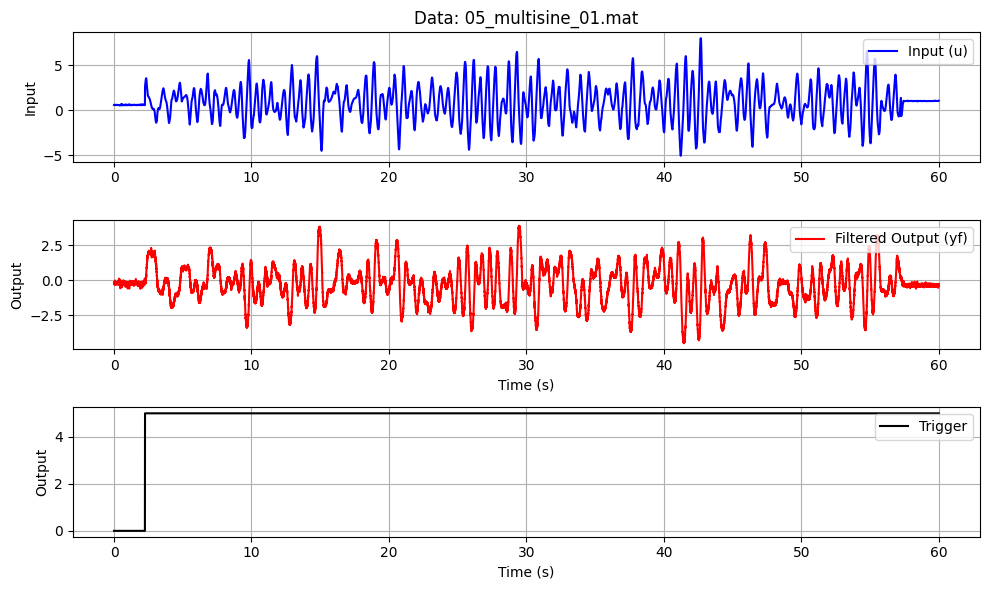

In [6]:
import scipy.io
import matplotlib.pyplot as plt
import os
from urllib.request import urlretrieve

# --- 1. Download Data ---
filename = '05_multisine_01.mat'
url = f"https://raw.githubusercontent.com/helonayala/sysid/main/data/{filename}"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    urlretrieve(url, filename)

# --- 2. Load Data ---
data = scipy.io.loadmat(filename)
t = data['time'].flatten()
ue = data['u'].flatten()
ye = data['y'].flatten()
trig = data['trigger'].flatten()

# --- 3. Plot u and yf ---
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, ue, color='blue', label='Input (u)')
plt.ylabel('Input')
plt.legend(loc='upper right')
plt.grid(True)
plt.title(f'Data: {filename}')

plt.subplot(3, 1, 2)
plt.plot(t, ye, color='red', label='Filtered Output (yf)')
plt.ylabel('Output')
plt.xlabel('Time (s)')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, trig, color='black', label='Trigger')
plt.ylabel('Output')
plt.xlabel('Time (s)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

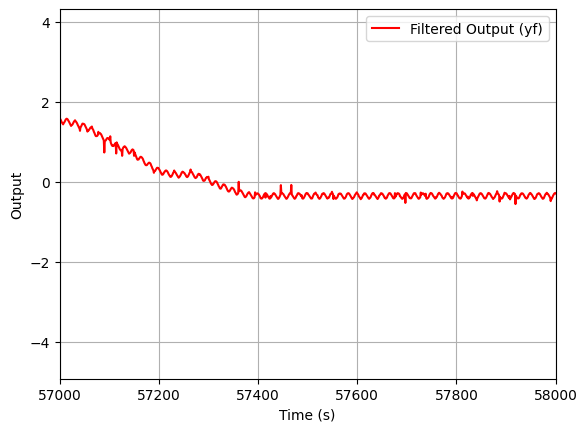

In [7]:
# calculate the sampling time and plot the end of experiment to get final sample (to trim)

Ts_calc = np.average( np.diff(t) )
Ts_calc # calculating the sampling time

plt.plot(ye, color='red', label='Filtered Output (yf)')
plt.xlim([57000, 58000])
plt.ylabel('Output')
plt.xlabel('Time (s)')
plt.legend(loc='upper right')
plt.grid(True)




# Pre-process data

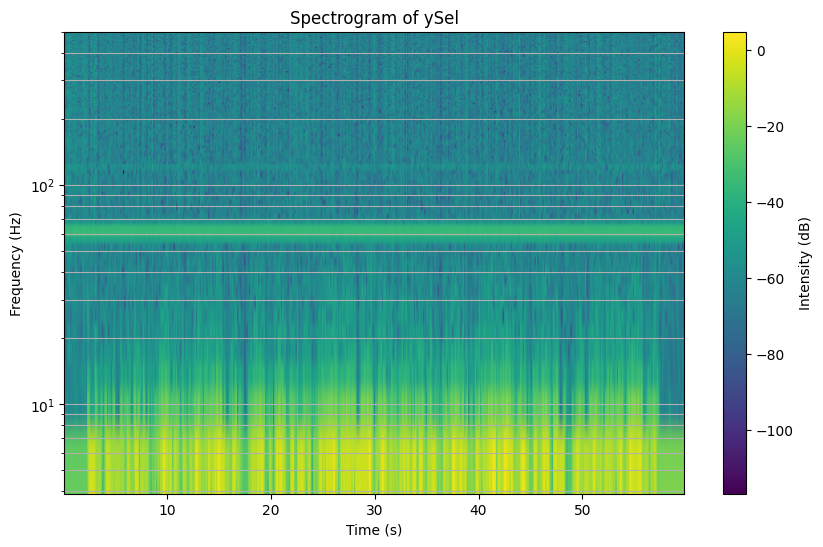

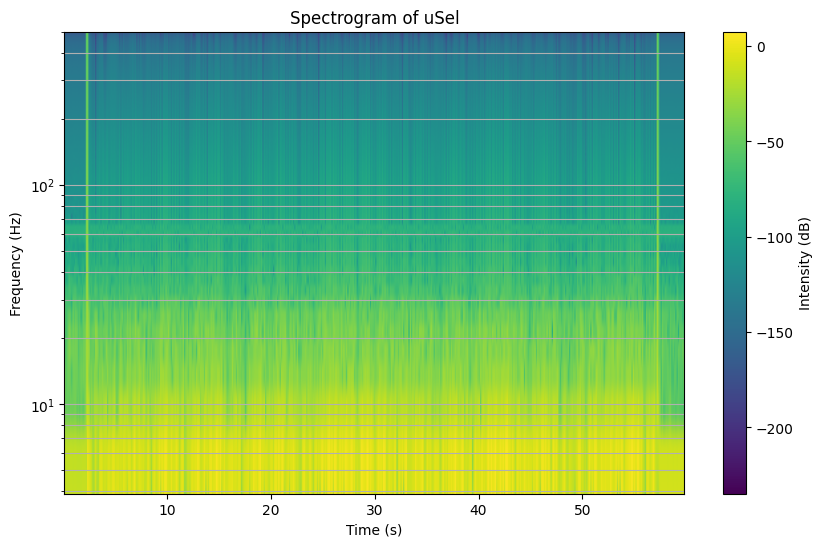

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Spectrogram of ySel (ye)
plt.figure(figsize=(10, 6))
Pyy, freqs, bins, im = plt.specgram(ye, NFFT=256, Fs=1000, noverlap=128) # Fs=1000 assuming 1ms sample time
plt.title('Spectrogram of ySel')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.yscale('log') # Set frequency axis to logarithmic
plt.colorbar(label='Intensity (dB)')
plt.ylim([freqs[1], freqs[-1]]) # Avoid plotting frequency 0
plt.grid(True, which='both', axis='y')
plt.show()

# Spectrogram of uSel (ue)
plt.figure(figsize=(10, 6))
Puu, freqs, bins, im = plt.specgram(ue, NFFT=256, Fs=1000, noverlap=128) # Fs=1000 assuming 1ms sample time
plt.title('Spectrogram of uSel')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.yscale('log') # Set frequency axis to logarithmic
plt.colorbar(label='Intensity (dB)')
plt.ylim([freqs[1], freqs[-1]]) # Avoid plotting frequency 0
plt.grid(True, which='both', axis='y')
plt.show()

Removed samples based on trigger and end acquisition. New signal length: 55152


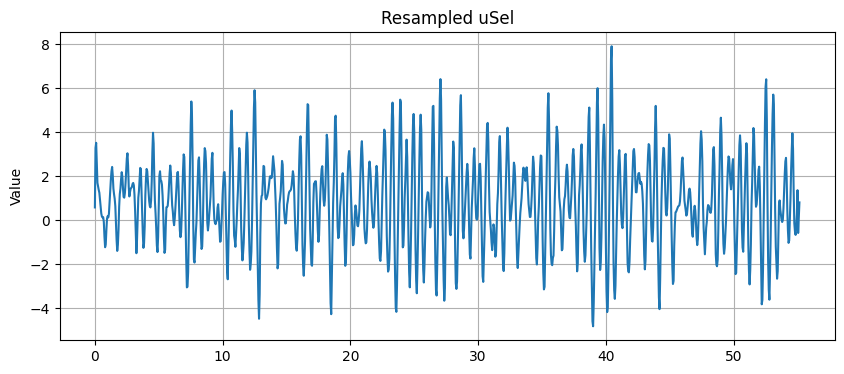

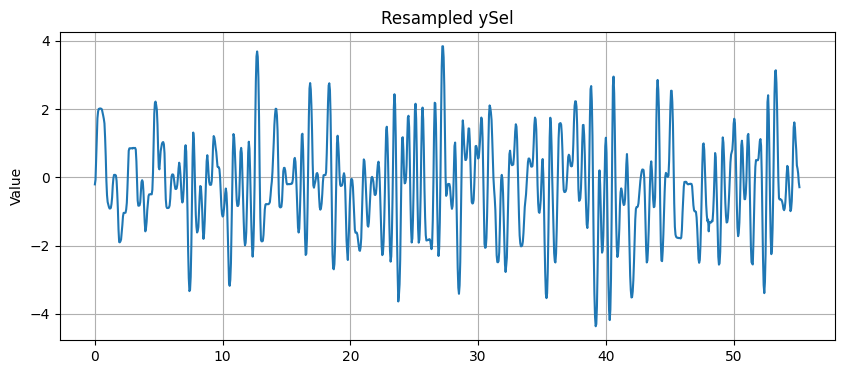

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# remove first samples when 'trigger' is set
# Find the first index where 'trig' is non-zero
trigger_start_idx = np.where(trig != 0)[0]
start_idx = trigger_start_idx[0]
end_idx = 57400
ue_processed = ue[start_idx:end_idx]
ye_processed = ye[start_idx:end_idx]
t_processed = t[start_idx:end_idx] - t[start_idx]
print(f"Removed samples based on trigger and end acquisition. New signal length: {len(ue_processed)}")

factor_resample = 50 # no of samples to divide total downsample

# Resample signals to 1000/factor_resample Hz
ue_resampled = ue_processed[::factor_resample]
ye_resampled = ye_processed[::factor_resample]
t_resampled  = t_processed[::factor_resample]

# start measurements in zero

# Plot resampled uSel
plt.figure(figsize=(10, 4))
plt.plot(t_resampled,ue_resampled)
plt.title('Resampled uSel')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Plot resampled ySel
plt.figure(figsize=(10, 4))
plt.plot(t_resampled,ye_resampled)
plt.title('Resampled ySel')
plt.ylabel('Value')
plt.grid(True)
plt.show()


# NARMAX

---



In [10]:
no_of_terms = 10
nu_model = 10
ny_model = 10
poly_order_model = 2

# 3. Instantiate and fit the NARX model
narx_model = NARX(nu=nu_model, ny=ny_model, poly_order_l=poly_order_model, selection_criteria=no_of_terms)
narx_model.fit(ue_resampled, ye_resampled)

print("--- Fitted NARX Model ---")
if narx_model.theta_ is not None and len(narx_model.theta_) > 0:
    print(f"Max lag internal (_max_lag_internal_): {narx_model._max_lag_internal_}")
    print("\nSelected terms & parameters (theta):")
    for i, term_name in enumerate(narx_model.selected_P_colnames_):
        print(f"  {i+1}. {term_name}: {narx_model.theta_[i]:.4f}")

    print("\nERR values for selected terms (%):")
    if narx_model.fit_results_['ERR_values'].size > 0:
        for i, err_val in enumerate(narx_model.fit_results_['ERR_values']):
            term_name = narx_model.selected_P_colnames_[i]
            print(f"  {term_name}: {err_val * 100:.10f}%")
    total_err_reduction = np.sum(narx_model.fit_results_['ERR_values']) * 100
    print(f"\nTotal ERR explained by selected terms: {total_err_reduction:.10f}%")
else:
    print("No terms were selected by FROLS, or fitting failed.")


--- Fitted NARX Model ---
Max lag internal (_max_lag_internal_): 10

Selected terms & parameters (theta):
  1. y(k-1): 1.2360
  2. y(k-2): -0.1544
  3. y(k-3): -0.0936
  4. u(k-1): 0.2353
  5. constant: -0.1664
  6. y(k-1)u(k-3): 0.0040
  7. u(k-1)u(k-9): -0.0049
  8. u(k-3): -0.0526
  9. y(k-3)u(k-8): -0.0042
  10. u(k-5): 0.0080

ERR values for selected terms (%):
  y(k-1): 84.7438108449%
  y(k-2): 12.8340677847%
  y(k-3): 0.8348245832%
  u(k-1): 0.3928227876%
  constant: 0.7819861266%
  y(k-1)u(k-3): 0.0124902017%
  u(k-1)u(k-9): 0.0074830574%
  u(k-3): 0.0076951655%
  y(k-3)u(k-8): 0.0042073424%
  u(k-5): 0.0022269612%

Total ERR explained by selected terms: 99.6216148554%


## Free-Run (FR) Simulation

In [11]:
max_lag = narx_model._max_lag_internal_

# estimation, not so difficult
ye_fr = ye_resampled[max_lag:] # Target for the FR part
ye_hat = narx_model.predict(ue_resampled, y_history_for_lags_or_osa=ye_resampled[:max_lag], mode='FR')


Starting Free-Run Simulation for 1094 steps...


FR Simulation:   0%|          | 0/1094 [00:00<?, ?step/s]

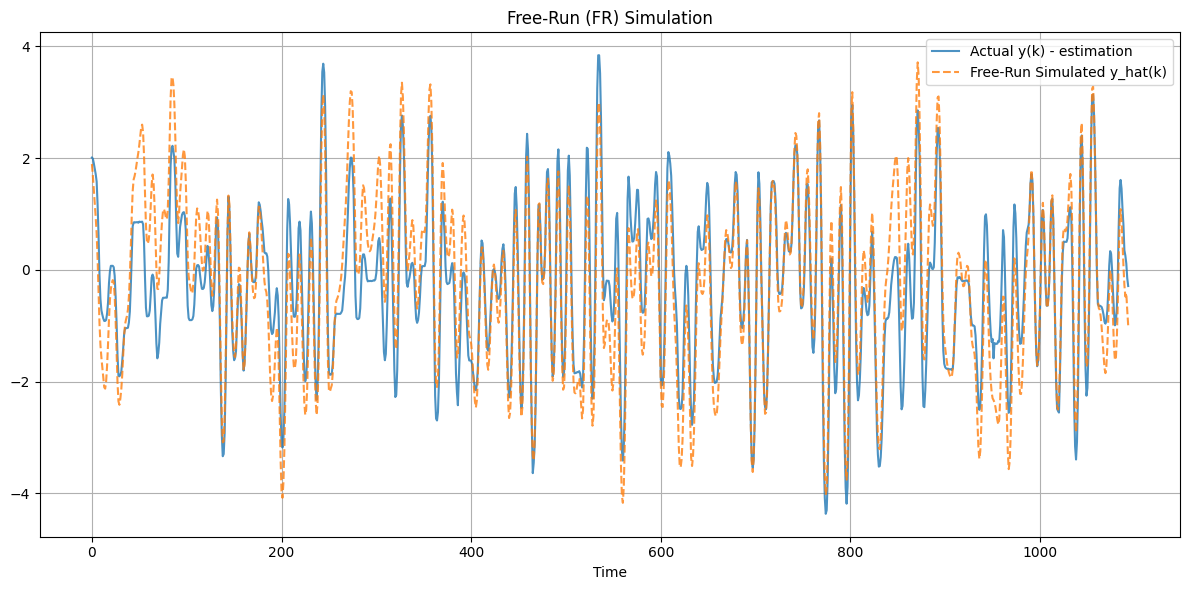

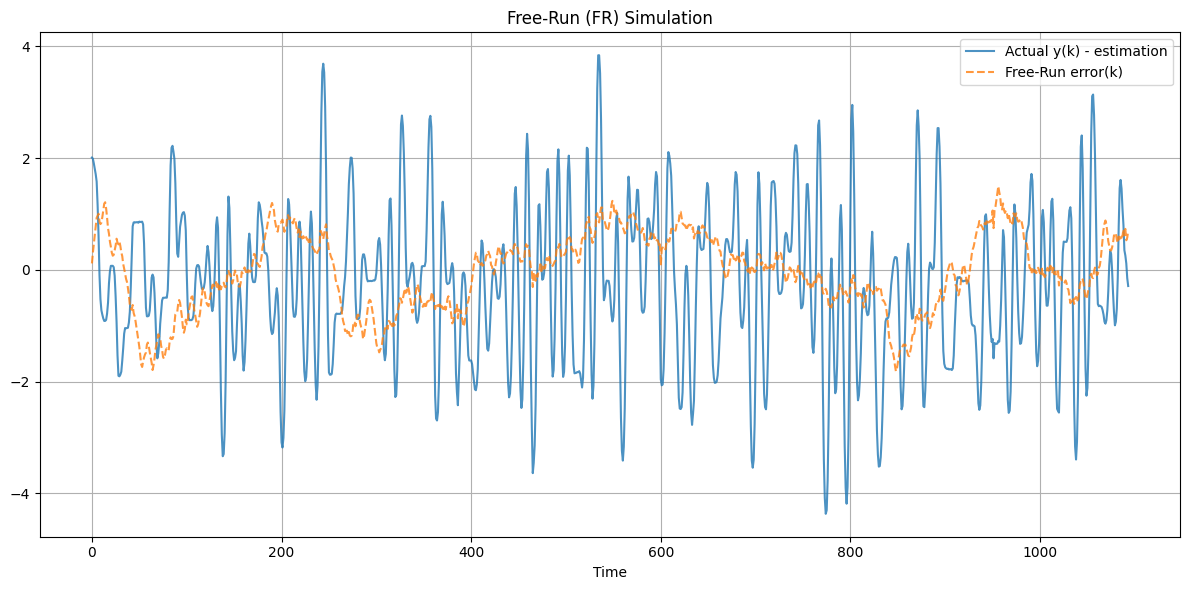

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(ye_fr, label='Actual y(k) - estimation', alpha=0.8)
plt.plot(ye_hat, label='Free-Run Simulated y_hat(k)', linestyle='--', alpha=0.8)
plt.title(f'Free-Run (FR) Simulation')
plt.xlabel(f'Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ye_fr, label='Actual y(k) - estimation', alpha=0.8)
plt.plot(ye_fr-ye_hat, label='Free-Run error(k)', linestyle='--', alpha=0.8)
plt.title(f'Free-Run (FR) Simulation')
plt.xlabel(f'Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# SINDY



In [13]:
!pip install pysindy

In [16]:
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.differentiation import FiniteDifference

# Data preparation
# Assuming ye_resampled is the state 'x' and ue_resampled is the input 'u'
x_sindy = ye_resampled.reshape(-1, 1) # Our state variable (output y)
u_sindy = ue_resampled.reshape(-1, 1) # Our control input u

# t_sindy = t_resampled.reshape(-1, 1) # time vec
t_sindy = t_resampled # time vec

# Get initial condition from the resampled data
x0_sindy = x_sindy[0]

# Calculate the sampling time for the resampled data and round to 2 decimals
dt = np.round(t_sindy[1]-t_sindy[0], 5)
print(f"Sampling time for SINDy model (dt): {dt} seconds")

# Define feature library
# Starting with PolynomialLibrary of degree 1, now increasing complexity
poly_library = PolynomialLibrary(degree=1) # Simplified polynomial degree
fourier_library = FourierLibrary(n_frequencies=2) # Simplified Fourier terms

# Combine feature libraries
feature_library = poly_library + fourier_library

# Define differentiator
# Finite difference is a simple choice
diff_method = FiniteDifference(order=2) # Simplified differentiation order

# Define optimizer
# Sparse regression optimizer, STLSQ (Sparse Thresholded Least Squares) is common
optimizer = ps.STLSQ(threshold=0.1, alpha=0.05) # Increased threshold for faster optimization

# Instantiate SINDy model
# feature_names are for the state variables (x)
# input_features are for the control inputs (u)
model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer,
    differentiation_method=diff_method
)

# Fit the model
print("\nFitting SINDy model...")
model.fit(x_sindy, u=u_sindy, t=dt)

# Print the identified model
print("\nIdentified SINDy Model:")
model.print()

Sampling time for SINDy model (dt): 0.05 seconds

Fitting SINDy model...

Identified SINDy Model:
(x0)' = -3.769 1 +  1.844 x0 +  5.404 u0 +  0.200 sin(1 x0) + -0.666 cos(1 x0) + -0.670 sin(1 u0) +  0.951 cos(1 u0) +  0.347 sin(2 u0) +  0.245 cos(2 u0)


In [ ]:
#######
# The results are rather disapointing with default configurations
#######

import matplotlib.pyplot as plt

# # Simulate the identified model
# # The simulate method takes initial condition, time points, and input
sindy_simulation = model.simulate(
    x0_sindy,
    t=t_sindy  , # Use the correctly constructed time vector
    u=u_sindy
)

# # --- Plotting the comparison ---
plt.figure(figsize=(12, 8))

# # Plot actual vs. simulated output
plt.subplot(2, 1, 1)
plt.plot(t_sindy, x_sindy, label='Actual y_resampled', alpha=0.8)
plt.plot(t_sindy[1:], sindy_simulation, label='SINDy Simulation', linestyle='--', alpha=0.8)
plt.title('SINDy Model Simulation vs. Actual Data')
plt.ylabel('Output (y)')
plt.legend()
plt.grid(True)

# # Plot the simulation error
sindy_error = x_sindy[1:] - sindy_simulation # Slice x_sindy to match sindy_simulation length
plt.subplot(2, 1, 2)
plt.plot(t_sindy[1:], sindy_error, label='Simulation Error', color='red', alpha=0.8) # Slice t_sindy for consistency
plt.title('SINDy Model Simulation Error')
plt.xlabel('Time (s)')
plt.ylabel('Error (y - y_hat)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/pysindy/_core.py:621: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


# ANN - NARX model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Helper functions for NARX
def matReg(y, u, ny, nu):
    p = np.max((ny, nu)) + 1
    (N, ) = y.shape
    (Nu, ) = u.shape

    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1, -1)

    target = y[p-1:N]
    Phi = np.zeros((N-p+1, ny+nu))

    for i in range(ny):
        Phi[:, i] = y[p-i-2: N-i-1]
    for i in range(nu):
        Phi[:, i+ny] = u[p-i-2: N-i-1]

    return (target, Phi)

def freeRun(model, y, u, ny, nu):
    p = max(ny, nu) + 1
    (N, ) = y.shape
    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1]

    for k in range(p, N+1):
        auxY = np.concatenate((yhat[(k-p):(k-1)], (0,)), axis=0)
        auxU = np.concatenate((u[(k-p):(k-1)], (0,)), axis=0)
        _, fr_input = matReg(auxY, auxU, ny, nu)
        yhat[k-1] = model.predict(torch.tensor(fr_input, dtype=torch.float32))

    return yhat[-(N-p+1):]

# ANN Architecture
class MyModel(nn.Module):
    def __init__(self, ninp, nneu, nout):
        super(MyModel, self).__init__()
        self.hidden1 = nn.Linear(ninp, nneu)
        self.hidden2 = nn.Linear(nneu, nneu)
        self.hidden3 = nn.Linear(nneu, nneu)
        self.output = nn.Linear(nneu, nout)

        nn.init.kaiming_normal_(self.hidden1.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.hidden2.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.hidden3.weight, nonlinearity='selu')
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='linear')

    def forward(self, x):
        x = F.selu(self.hidden1(x))
        x = F.selu(self.hidden2(x))
        x = F.selu(self.hidden3(x))
        return self.output(x)

    def predict(self, x):
        with torch.no_grad():
            return self.forward(x)

In [ ]:
# --- DATA PREPARATION ---
# Use your provided data here
# ye = your_estimation_output_vector
# ue = your_estimation_input_vector
# yt = your_test_output_vector
# ut = your_test_input_vector

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Model Orders
ny, nu = 5, 5

# Generate Regression Matrices
Ye, Phie = matReg(ye_resampled, ue_resampled, ny, nu)
# Yt, Phit = matReg(yt, ut, ny, nu)

# Convert to Tensors
Phie_t = torch.tensor(Phie, dtype=torch.float32)
Ye_t = torch.tensor(Ye, dtype=torch.float32)
# Phit_t = torch.tensor(Phit, dtype=torch.float32)
# Yt_t = torch.tensor(Yt, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Phie_t, Ye_t), batch_size=32, shuffle=True)

# --- MODEL SETUP ---
ninp = Phie.shape[1]
model = MyModel(ninp, nneu=80, nout=1)
optimizer = optim.NAdam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- TRAINING ---
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # Squeeze the model output to ensure it's 1D for loss calculation
        loss = criterion(model(inputs).squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}')

# --- EVALUATION ---
# One-step ahead
y_test_pred1 = model.predict(Phie_t)
y_test_pred1 = y_test_pred1.squeeze() # Squeeze to make it a 1D tensor
print(f'R2 One-Step Test: {r2_score(Ye_t, y_test_pred1):.4f}')

# Free Run (Simulation)
y_test_pred_fr_np = freeRun(model, ye_resampled, ue_resampled, ny, nu)
y_test_pred_fr = torch.tensor(y_test_pred_fr_np, dtype=torch.float32) # Convert to 1D torch tensor
print(f'R2 Free-Run Test: {r2_score(Ye_t, y_test_pred_fr):.4f}')

In [ ]:
import matplotlib.pyplot as plt

# Model Orders (from cell Wy6qtBCkRE6I)
ny, nu = 5, 5
p = max(ny, nu) + 1 # Max lag used in matReg function, determines data shift

# Adjust time axis to match the length of Ye_t, y_test_pred1, y_test_pred_fr
t_plot = t_resampled[p-1:]

# Create a figure with two subplots
plt.figure(figsize=(12, 10))

# Subplot 1: Actual vs. Predictions
plt.subplot(2, 1, 1) # 2 rows, 1 column, first plot
plt.plot(t_plot, Ye_t, 'k', label='Real')
plt.plot(t_plot, y_test_pred1, 'g--', label='OSA Prediction')
plt.plot(t_plot, y_test_pred_fr, 'r--', label='Free-Run Prediction')
plt.legend()
plt.title('ANN Model Performance on Estimation Data (Actual vs. Predictions)')
plt.xlabel('Time (s)')
plt.ylabel('Output (y)')
plt.grid(True)

# Subplot 2: Residuals
plt.subplot(2, 1, 2) # 2 rows, 1 column, second plot
plt.plot(t_plot, Ye_t - y_test_pred1, 'g:', label='OSA Residual (Real - OSA Pred)')
plt.plot(t_plot, Ye_t - y_test_pred_fr, 'r:', label='Free-Run Residual (Real - FR Pred)')
plt.legend()
plt.title('ANN Model Prediction Residuals')
plt.xlabel('Time (s)')
plt.ylabel('Residual (y - y_hat)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Install Neural ODE Libraries



In [ ]:
!pip install torchdiffeq

## Define Neural ODE Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

# 2. Define ODEFunc class
class ODEFunc(nn.Module):
    def __init__(self, state_dim, u_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.state_dim = state_dim
        self.u_dim = u_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim + u_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, state_dim)
        )
        # Initialize weights as specified
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                if m == self.net[-1]: # Last layer is output layer, use 'linear'
                    nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
                else: # Hidden layers, use 'selu'
                    nn.init.kaiming_normal_(m.weight, nonlinearity='selu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, t, x, u_series, t_series):
        # t is a scalar tensor representing the current time
        # x is (batch_size, state_dim) representing the current state
        # u_series is (num_time_points, u_dim) - full input time series
        # t_series is (num_time_points) - corresponding time points for u_series

        # Ensure t is within the bounds of t_series for safe interpolation
        t_clamped = torch.clamp(t, t_series[0], t_series[-1])

        # Find indices for linear interpolation
        # k is the index such that t_series[k-1] <= t_clamped < t_series[k]
        # If t_clamped is less than t_series[0], k will be 0. If t_clamped is >= t_series[-1], k will be len(t_series).
        k = torch.searchsorted(t_series, t_clamped, right=True)

        # Clamp k to ensure valid indices for t_low and t_high
        k_upper = torch.clamp(k, 1, len(t_series) - 1)
        k_lower = k_upper - 1

        t_low = t_series[k_lower]
        t_high = t_series[k_upper]
        u_low = u_series[k_lower]
        u_high = u_series[k_upper]

        # Perform linear interpolation for u_t
        if (t_high - t_low).abs() < 1e-6: # Handle potential division by zero or very small interval
            u_t = u_low
        else:
            alpha = (t_clamped - t_low) / (t_high - t_low)
            u_t = u_low + alpha * (u_high - u_low)

        # Reshape u_t to (1, u_dim) and then expand to (batch_size, u_dim)
        # for concatenation with x (batch_size, state_dim)
        u_t_expanded = u_t.unsqueeze(0).expand(x.shape[0], -1)

        # Concatenate state x and interpolated input u_t
        net_input = torch.cat((x, u_t_expanded), dim=-1)

        return self.net(net_input)

# 3. Define NeuralODE class
class NeuralODE(nn.Module):
    def __init__(self, state_dim, u_dim, hidden_dim, ode_method='rk4'):
        super(NeuralODE, self).__init__()
        self.ode_func = ODEFunc(state_dim, u_dim, hidden_dim)
        self.ode_method = ode_method

    def forward(self, x0, t_eval, u_series, t_series):
        # x0: (batch_size, state_dim) - initial state
        # t_eval: (num_time_points_to_eval) - time points at which to evaluate the ODE solution
        # u_series: (num_time_points_u, u_dim) - full input time series
        # t_series: (num_time_points_u) - corresponding time points for u_series

        # Call odeint, passing u_series and t_series as additional arguments to ODEFunc.forward
        pred_x = odeint(self.ode_func, x0, t_eval, args=(u_series, t_series), method=self.ode_method,
                        rtol=1e-3, atol=1e-3)

        return pred_x

print("Neural ODE classes (ODEFunc, NeuralODE) defined successfully.")

## Prepare Data for Neural ODE

In [ ]:
import torch

# 1. Convert numpy arrays to PyTorch tensors and reshape
y_tensor = torch.tensor(ye_resampled, dtype=torch.float32).reshape(-1, 1)
u_tensor = torch.tensor(ue_resampled, dtype=torch.float32).reshape(-1, 1)
t_tensor = torch.tensor(t_resampled, dtype=torch.float32)

# 2. Define state_dim and u_dim
state_dim = y_tensor.shape[1]
u_dim = u_tensor.shape[1]

# 3. Extract initial state x0
x0 = y_tensor[0:1] # x0 should be (1, state_dim)

print(f"y_tensor shape: {y_tensor.shape}")
print(f"u_tensor shape: {u_tensor.shape}")
print(f"t_tensor shape: {t_tensor.shape}")
print(f"state_dim: {state_dim}")
print(f"u_dim: {u_dim}")
print(f"x0 shape: {x0.shape}")
print("Data preparation for Neural ODE complete.")

In [ ]:
from sklearn.model_selection import train_test_split

N_total = len(t_tensor)
N_train = int(N_total * 0.8)

# Training data
t_train = t_tensor[:N_train]
u_train = u_tensor[:N_train]
y_train = y_tensor[:N_train]

# Validation data
t_val = t_tensor[N_train:]
u_val = u_tensor[N_train:]
y_val = y_tensor[N_train:]

# For Neural ODE, x0 for training will be y_train[0:1]
x0_train = y_train[0:1]

# For Neural ODE, x0 for validation will be y_val[0:1]
x0_val = y_val[0:1]

print(f"Total samples: {N_total}")
print(f"Training samples: {N_train} (t_train, u_train, y_train shapes: {t_train.shape}, {u_train.shape}, {y_train.shape})")
print(f"Validation samples: {N_total - N_train} (t_val, u_val, y_val shapes: {t_val.shape}, {u_val.shape}, {y_val.shape})")
print(f"x0_train shape: {x0_train.shape}")
print(f"x0_val shape: {x0_val.shape}")
print("Data split into training and validation sets successfully.")

In [ ]:
import torch.optim as optim

# 1. Define model parameters
hidden_dim = 64 # Size of the hidden layers in the ODEFunc network
ode_method = 'rk4' # Or 'dopri5', 'adams', etc. 'rk4' is a good starting point.

# 2. Instantiate the NeuralODE model
# state_dim and u_dim were already defined in the previous step
neural_ode_model = NeuralODE(state_dim=state_dim, u_dim=u_dim, hidden_dim=hidden_dim, ode_method=ode_method)

# 3. Define the optimizer and loss function
optimizer_node = optim.Adam(neural_ode_model.parameters(), lr=1e-3)
loss_fn_node = nn.MSELoss()

print(f"Neural ODE model initialized with state_dim={state_dim}, u_dim={u_dim}, hidden_dim={hidden_dim}, and ODE method='{ode_method}'.")
print(f"Optimizer: {type(optimizer_node).__name__}, Loss Function: {type(loss_fn_node).__name__}.")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

# 2. Define ODEFunc class
class ODEFunc(nn.Module):
    def __init__(self, state_dim, u_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.state_dim = state_dim
        self.u_dim = u_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim + u_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, state_dim)
        )
        # Initialize weights as specified
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                if m == self.net[-1]: # Last layer is output layer, use 'linear'
                    nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
                else: # Hidden layers, use 'selu'
                    nn.init.kaiming_normal_(m.weight, nonlinearity='selu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # These will be set by NeuralODE.forward before odeint is called
        self.u_series = None
        self.t_series = None

    def forward(self, t, x): # Removed u_series, t_series from arguments
        # Access u_series and t_series from self
        u_series = self.u_series
        t_series = self.t_series

        if u_series is None or t_series is None:
            raise RuntimeError("u_series and t_series must be set in ODEFunc before calling forward via odeint.")

        # Ensure t is within the bounds of t_series for safe interpolation
        t_clamped = torch.clamp(t, t_series[0], t_series[-1])

        # Find indices for linear interpolation
        k = torch.searchsorted(t_series, t_clamped, right=True)

        # Clamp k to ensure valid indices for t_low and t_high
        k_upper = torch.clamp(k, 1, len(t_series) - 1)
        k_lower = k_upper - 1

        t_low = t_series[k_lower]
        t_high = t_series[k_upper]
        u_low = u_series[k_lower]
        u_high = u_series[k_upper]

        # Perform linear interpolation for u_t
        if (t_high - t_low).abs() < 1e-6: # Handle potential division by zero or very small interval
            u_t = u_low
        else:
            alpha = (t_clamped - t_low) / (t_high - t_low)
            u_t = u_low + alpha * (u_high - u_low)

        # Reshape u_t to (1, u_dim) and then expand to (batch_size, u_dim)
        u_t_expanded = u_t.unsqueeze(0).expand(x.shape[0], -1)

        # Concatenate state x and interpolated input u_t
        net_input = torch.cat((x, u_t_expanded), dim=-1)

        return self.net(net_input)

# 3. Define NeuralODE class
class NeuralODE(nn.Module):
    def __init__(self, state_dim, u_dim, hidden_dim, ode_method='rk4'):
        super(NeuralODE, self).__init__()
        self.ode_func = ODEFunc(state_dim, u_dim, hidden_dim)
        self.ode_method = ode_method

    def forward(self, x0, t_eval, u_series, t_series):
        # x0: (batch_size, state_dim) - initial state
        # t_eval: (num_time_points_to_eval) - time points at which to evaluate the ODE solution
        # u_series: (num_time_points_u, u_dim) - full input time series
        # t_series: (num_time_points_u) - corresponding time points for u_series

        # Set u_series and t_series as attributes of ode_func
        self.ode_func.u_series = u_series
        self.ode_func.t_series = t_series

        # Call odeint. Now odeint only passes t and x to ode_func.forward
        pred_x = odeint(self.ode_func, x0, t_eval, method=self.ode_method,
                        rtol=1e-3, atol=1e-3)

        # Clear u_series and t_series from ode_func to avoid statefulness issues
        self.ode_func.u_series = None
        self.ode_func.t_series = None

        return pred_x

In [ ]:
import torch.optim as optim

# Re-instantiate the NeuralODE model and optimizer
# This ensures the model uses the latest class definition with the corrected odeint call
neural_ode_model = NeuralODE(state_dim=state_dim, u_dim=u_dim, hidden_dim=hidden_dim, ode_method=ode_method)
optimizer_node = optim.Adam(neural_ode_model.parameters(), lr=1e-3)
loss_fn_node = nn.MSELoss()

epochs_node = 1000 # Number of training epochs

for epoch in range(epochs_node):
    neural_ode_model.train()
    optimizer_node.zero_grad()

    # Forward pass: Predict y values for the training data
    # x0_train is (1, state_dim)
    # t_train is (N_train,)
    # u_train is (N_train, u_dim)
    pred_y_train = neural_ode_model(x0_train, t_train, u_train, t_train)

    # The output of odeint is (N_train, batch_size, state_dim).
    # Since x0_train is (1,1), pred_y_train will be (N_train, 1, 1).
    # We need to squeeze it to (N_train, 1) for comparison with y_train.
    pred_y_train_squeezed = pred_y_train.squeeze(1)

    # Calculate loss
    loss = loss_fn_node(pred_y_train_squeezed, y_train)

    # Backward pass and optimize
    loss.backward()
    optimizer_node.step()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch + 1}/{epochs_node}, Training Loss: {loss.item():.6f}')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

neural_ode_model.eval() # Set the model to evaluation mode

# Evaluate on Training Data
with torch.no_grad():
    pred_y_train_eval = neural_ode_model(x0_train, t_train, u_train, t_train).squeeze(1)
    r2_train = r2_score(y_train.numpy(), pred_y_train_eval.numpy())

print(f"R2 score on training data: {r2_train:.4f}")

# Plotting Training Data Prediction
plt.figure(figsize=(12, 6))
plt.plot(t_train.numpy(), y_train.numpy(), label='Actual y_train', alpha=0.8)
plt.plot(t_train.numpy(), pred_y_train_eval.numpy(), label='Neural ODE Predicted y_train', linestyle='--', alpha=0.8)
plt.title('Neural ODE Training Prediction vs. Actual Data')
plt.xlabel('Time (s)')
plt.ylabel('Output (y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Training Residuals
plt.figure(figsize=(12, 6))
plt.plot(t_train.numpy(), y_train.numpy() - pred_y_train_eval.numpy(), label='Training Residual', color='red', alpha=0.8)
plt.title('Neural ODE Training Residuals')
plt.xlabel('Time (s)')
plt.ylabel('Error (y - y_hat)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
